# Project Freedom
### Samuel Thomas

### Exploring and classifying weather images using different methods learned in MAS4115. In particular, comparison of different CNN's used for transfer learning will be conducted.

The following methods are used:
 1. EDA with tSNE
 2. Classification with Transfer Learning
  * EfficientNetB0
  * MobileNetV2
  * ResNet50

### Dataset: [Weather Image Recognition](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset)

This dataset is a collection of 6862 images of 11 different weather phenomena. The images are split into files named by the classification. The classes are as follows:
0. dew
1. fog/smog
2. frost
3. glaze
4. hail
5. lightning
6. rain
7. rainbow
8. rime
9. sandstorm
10. snow

### Goal: Classify weather from an image

The goal of this project is to classify weather based on an image using Transfer Learning. Images will be classified using 3 different pre-learned CNN's. The highest predictive performance, while balancing efficiency, is desired.

# Data Processing

Bear with me...this gets a little messy/technical.

## Imports

In [ ]:
# General
import numpy as np
import matplotlib.pyplot as plt

# Image imports
from PIL import Image # Get and Resize images
import glob # Get images from folder

# TSNE imports
from sklearn.manifold import TSNE
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Neural net imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input

# sklearn Metrics imports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Loading Dataset

Code to load full dataset from Kaggle onto Colab. Requires either inputting or uploading your own Kaggle API Key. Documentation: https://www.kaggle.com/docs/api

In [ ]:
! pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/jehanbhathena/weather-dataset')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: samuelthomas4
Your Kaggle Key: ··········


100%|██████████| 587M/587M [00:15<00:00, 40.7MB/s]


### Single Image

Code to load a single image into the notebook. Then, resizing the image and converting it to a numpy array.

(400, 257)
RGB


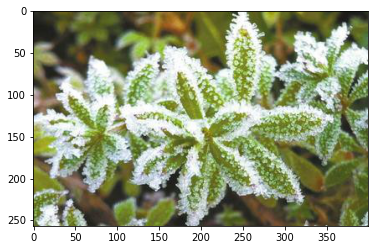

(32, 32)
RGB
(32, 32, 3)


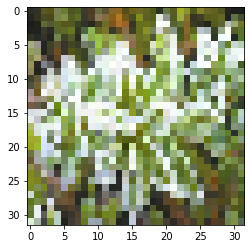

In [ ]:
# Brings image into notebook
image = Image.open('weather-dataset/dataset/frost/3600.jpg')
print(image.size)
print(image.mode)

# Plotting original image
plt.imshow(image)
plt.show()

# Resizing image to desired size
image1 = image.resize((32,32), resample = 0)
print(image1.size)
print(image1.mode)

# Converting image to numpy array
numpydata = np.asarray(image1)
# Plotting image in numpy array form
plt.imshow(numpydata)
plt.plot()
print(numpydata.shape)

## Loading All Images into Notebook

The images are set in 11 labeled folders. We must access the folders to load images, create classifications, and encode the classifications for use during transfer learning.

#### image_uploader() Function

This function extracts every image from a folder with the folder name specified as input. Then, it converts the image into a numpy array as a square RGB image with the dimension specified. For our purposes, we use DIM = 224 to output a numpy array of shape (224, 224, 3) for each image in a given folder.

Returns:

imarray - A numpy array of all images with specified dimension in the specified folder

filearray - A flat numpy array of the file names of each image in imarray. We don't really use it explicitly in this notebook, but it is nice for the purposes on finding the original image in the dataset.

classarray - A flat array of the class that each image belongs to. In this case, it is the name of the folder.

In [ ]:
def image_uploader(file_name, DIM):
  # Instantiating empty numpy arrays
  imarray = np.empty(0, dtype = np.int8)
  filearray = np.empty(0)
  classarray = np.empty(0)

  # Creating file path string with file_name argument
  file_folder_string = 'weather-dataset/dataset/'
  file_folder_string += file_name
  file_folder_string += '/*.jpg'

  # Accessing the file and grabbing all images inside
  images = glob.glob(file_folder_string)
  for image in images:
      with open(image, 'rb') as file:
          img = Image.open(file)
          # Resizing image to desired dimension (DIM)
          img = img.resize((DIM, DIM), resample = 0)

          # Converting image to numpy array
          img_array = np.asarray(img)

          # Checks that image is RGB
          if img_array.shape == (DIM, DIM, 3):
            imarray = np.append(imarray,img_array)

            # Tracks file name for image to check accuracy
            filearray = np.append(filearray, file)

            # Tracks classification for each image
            classarray = np.append(classarray, file_name)

  # Returns arrays with image, filenames, classes for every image in file
  return imarray, filearray, classarray

#### get_ims() Function

This function iterates through every folder in the dataset and calls the image_uploader function to get numpy arrays of images, filenames, and classes. Next, it numerically codes the classes. Then, it combines all these arrays into one large data array.

Returns:

final_ims: Numpy array containing all images in the dataset with shape (N_Images, DIM, DIM, 3)

final_files: A flat numpy array containing all filenames of images in the dataset.

final_classes: A flat numpy array containing all classifiers of images in the dataset.

final_classes_num: A flat numpy array containing all classifiers in numerical form of images in the dataset.

In [ ]:
def get_ims(DIM):
  # Instantiating empty numpy arrays
  final_ims = np.empty((0, DIM, DIM, 3),dtype = np.int8)
  final_files = np.empty(0)
  final_classes = np.empty(0)
  final_classes_num = np.empty(0, dtype = np.int8)

  # Tracker to encode classes as numbers
  class_track = 0

  # For loop to get images from each file
  for file_name in ['dew','fogsmog','frost','glaze','hail',
                    'lightning','rain','rainbow','rime',
                    'sandstorm','snow']:
    # Function call to image_uploader with each file_name, DIM
    ims, files, classes = image_uploader(file_name, DIM)

    # Reshapes images to standard RGB shape
    ims = ims.reshape(files.shape[0], DIM, DIM, 3)

    # Adds images, files, classes to one array with all data
    final_ims = np.append(final_ims, ims, axis = 0)
    final_files = np.append(final_files, files)
    final_classes = np.append(final_classes, classes)
    final_classes_num = np.append(final_classes_num, 
                                  class_track*np.ones(classes.shape,
                                                      dtype = np.int8))
    # Updates class number
    class_track += 1

  print(final_ims.shape)
  print(final_files.shape)
  print(final_classes.shape)
  print(final_classes_num.shape)

  return final_ims, final_files, final_classes, final_classes_num

#### Call to get Images

This takes a little while...about 3-4min.

In [ ]:
final_ims, final_files, final_classes, final_classes_num = get_ims(224)

(6688, 224, 224, 3)
(6688,)
(6688,)
(6688,)


## Visualization

Visualization of one image in each class with the title of the class as the image title.

In [ ]:
# Takes a list/array of images and plots them spaced horizontally
def plot_images_in_a_row(ims, labs):    
  _, axs = plt.subplots(1, len(ims), figsize = (20,5))
  for im, ax, lab in zip(ims, axs.ravel(), labs):
    ax.imshow(im)
    ax.title.set_text(lab)
    ax.axis('off')

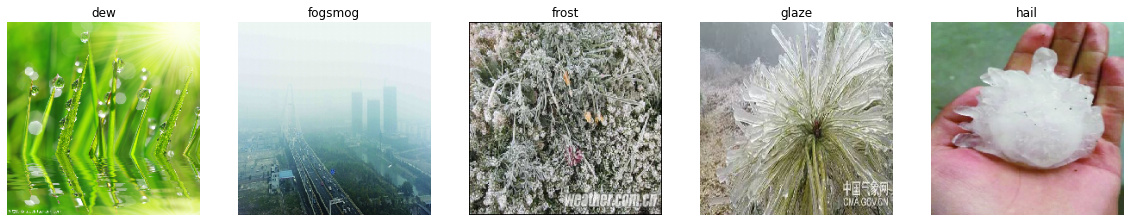

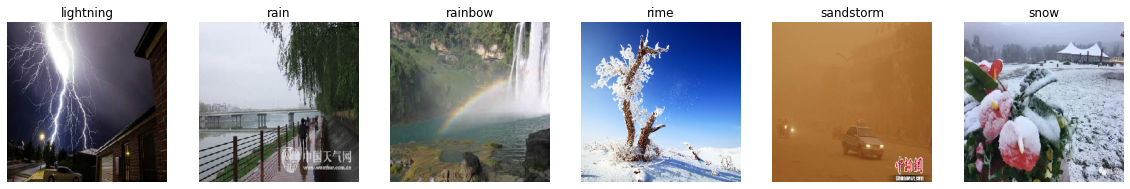

In [ ]:
# Visualizing an image in each class
for im in [[300, 1440, 1900, 2580, 3100],
           [3500, 3990, 4200, 5400, 6000, 6600]]:
  plot_images_in_a_row(final_ims[im], final_classes[im])
  plt.show()

## Train Test Split

Here, we split the data into 5000 training images and 1688 testing images.

First, we randomize the order of the images. Note that we also reorder the classifications in the same order as the images after randomization.

Then, we actually split the data by taking the first 5000 of our randomized images as our training set, and the last 1688 images as our testing set.

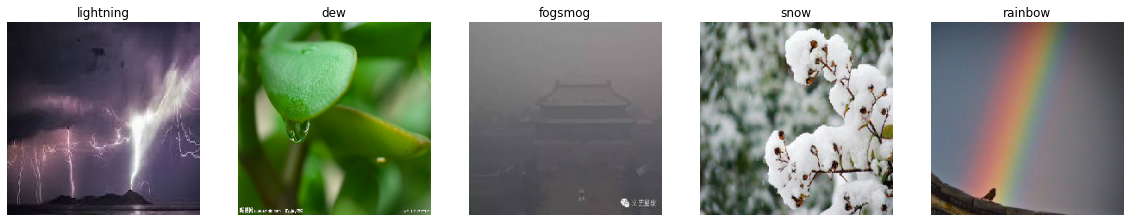

In [ ]:
# Randomizing indices
random_indices = np.random.permutation(len(final_ims))

# Reording the image array via randomized indices
final_ims = final_ims[random_indices]

# Reording the image classes arrays via randomized indices
# Note each image is still attached to its correct class
final_classes = final_classes[random_indices]
final_classes_num = final_classes_num[random_indices]

# Plotting first five images in reordered arrays for proof
for i in [[0,1,2,3,4]]:
  plot_images_in_a_row(final_ims[i], final_classes[i])
  plt.show()

In [ ]:
# Taking first 5000 images as the training dataset
x_train = final_ims[:5000]
y_train = final_classes[:5000]
y_train_num = final_classes_num[:5000]

# Taking the last 1688 images as the testing dataset
x_test = final_ims[5000:]
y_test = final_ims[5000:]
y_test_num = final_classes_num[5000:]

# Creating vectors for classifiers for Neural Nets
y_train_cat = keras.utils.to_categorical(y_train_num)
y_test_cat = keras.utils.to_categorical(y_test_num)

# Exploratory Data Analysis with tSNE

To get a better idea of how the dataset looks, we will use tSNE to conduct some exploratory data analysis. To do so, we use tSNE and plot the images on a 2D surface to see how they cluster. Note that tSNE only separates images by color of the whole image.

**Takeaways**

There are a few very distinct sets of images. Even though color is the only factor separating the images, it seems that some image classes will be accurately classified:
1. Many of the dew images are up-close images of grass and other plants. For this reason, they are predominantly green. Additionally, no other images are green. I believe dew will be accurately classified.
2. Many of the sandstorm images are orange. Further, they separate themselves from the rest due to the coloring.

However, there are some images that appear very similar in both color and shape. There are 3 types of ice in this image dataset: Frost, Glaze, and Rime. These images, to my untrained eye at least, do not appear to have any defining feature that separates them from being one type of ice versus another. Further, many of the snow images appear to be very similar in style to the ices. For this reason, I believe that the models will have difficulty classifying between the three types of ice, and possibly snow.

In [ ]:
# Setting parameters
num_iters = 2000 # Number of iterations
perplex = 14 # Perplexity
my_random_state = 123 # Setting random state
n_ims = 3000 # Number of images to fit with TSNE (for runtime purposes)

# Creating TSNE instance with parameters
tSNE = TSNE(n_components = 2, n_iter = num_iters, 
            perplexity = perplex, random_state = my_random_state,
            init = 'random', learning_rate = 200.0)

# Fitting TSNE on training images
images_reduced = tSNE.fit_transform(x_train[:n_ims].reshape(n_ims, 224*224*3))

#### Plotting TSNE output

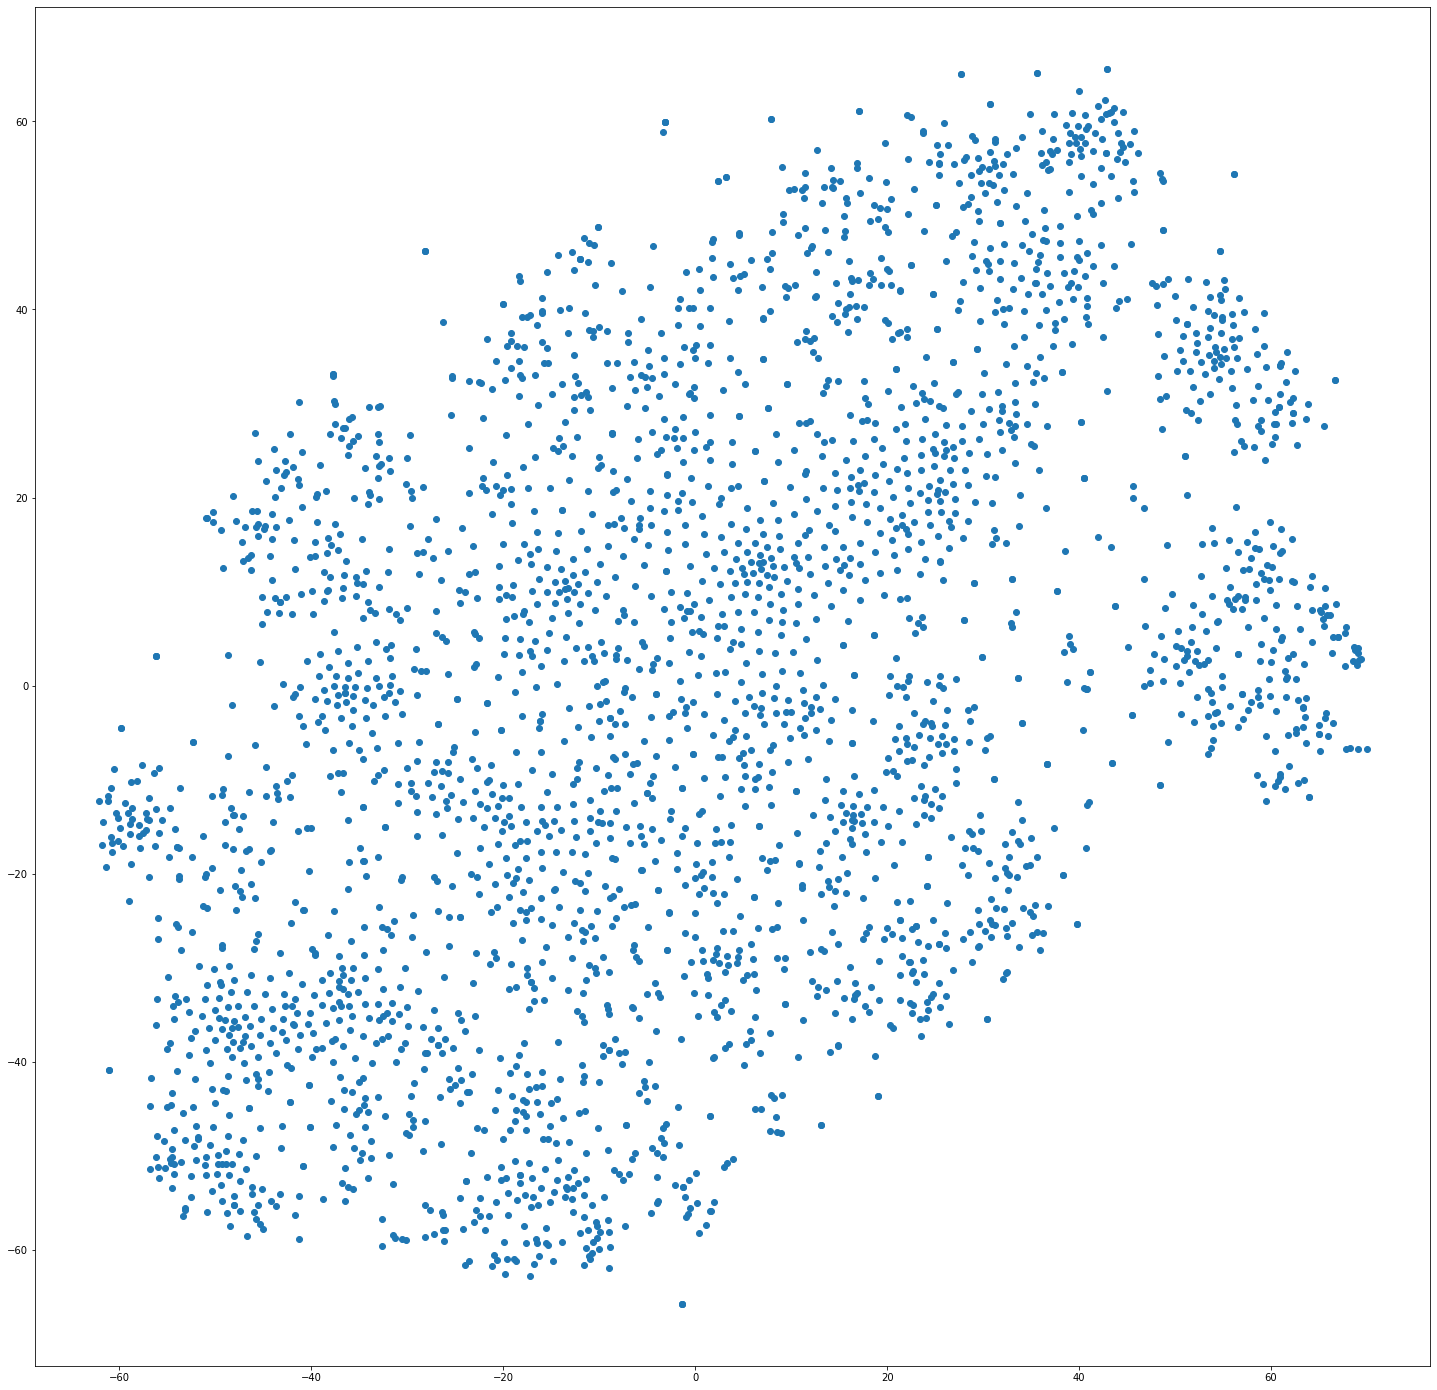

In [ ]:
plt.figure(figsize = (25,25))
plt.scatter(images_reduced.T[0], images_reduced.T[1])

#### Plotting TSNE output with image classes represented by colors

A couple labels tend to separate themselves, but most do not:
  * Separated labels: Light green at top right (Dew), Orange on right (Sandstorm)

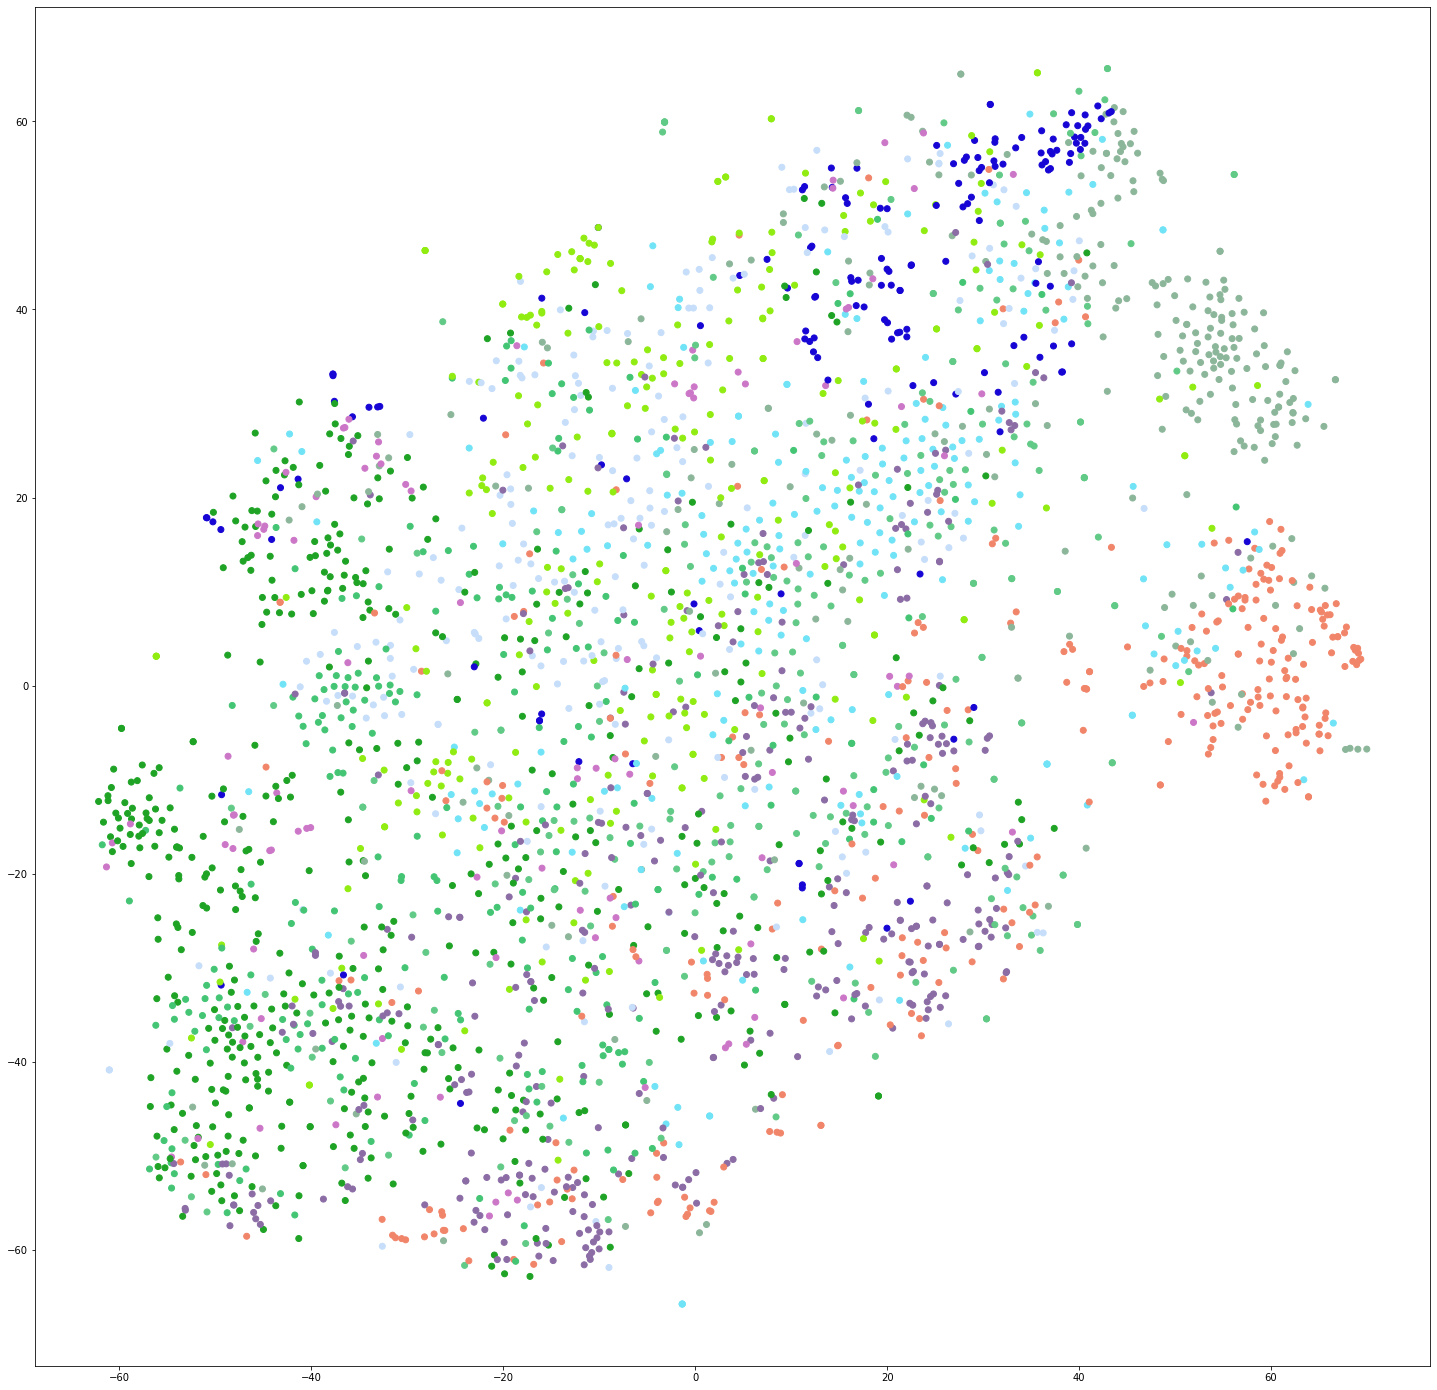

In [ ]:
# Creating color for each class
np.random.seed(0) # Fixing the random colors
label_colors = np.random.random((11, 3))
# Creating array of colors specified by label
colors = label_colors[y_train_num[:n_ims]].reshape(n_ims,3)

# Plotting output with classes
plt.figure(figsize = (25,25))
plt.scatter(images_reduced.T[0], images_reduced.T[1], c = colors)

#### Plotting TSNE output with images

In [ ]:
# Plots each image at its location in TSNE
def plot_image_at_point(im, xy, zoom = 1):    
  dxy = np.random.rand(2)/100 * plt.ylim()
  plt.arrow(*xy, *dxy)
  ab = AnnotationBbox(OffsetImage(im, zoom=zoom, cmap = 'gray_r'), xy + dxy, frameon=False)
  plt.gca().add_artist(ab)

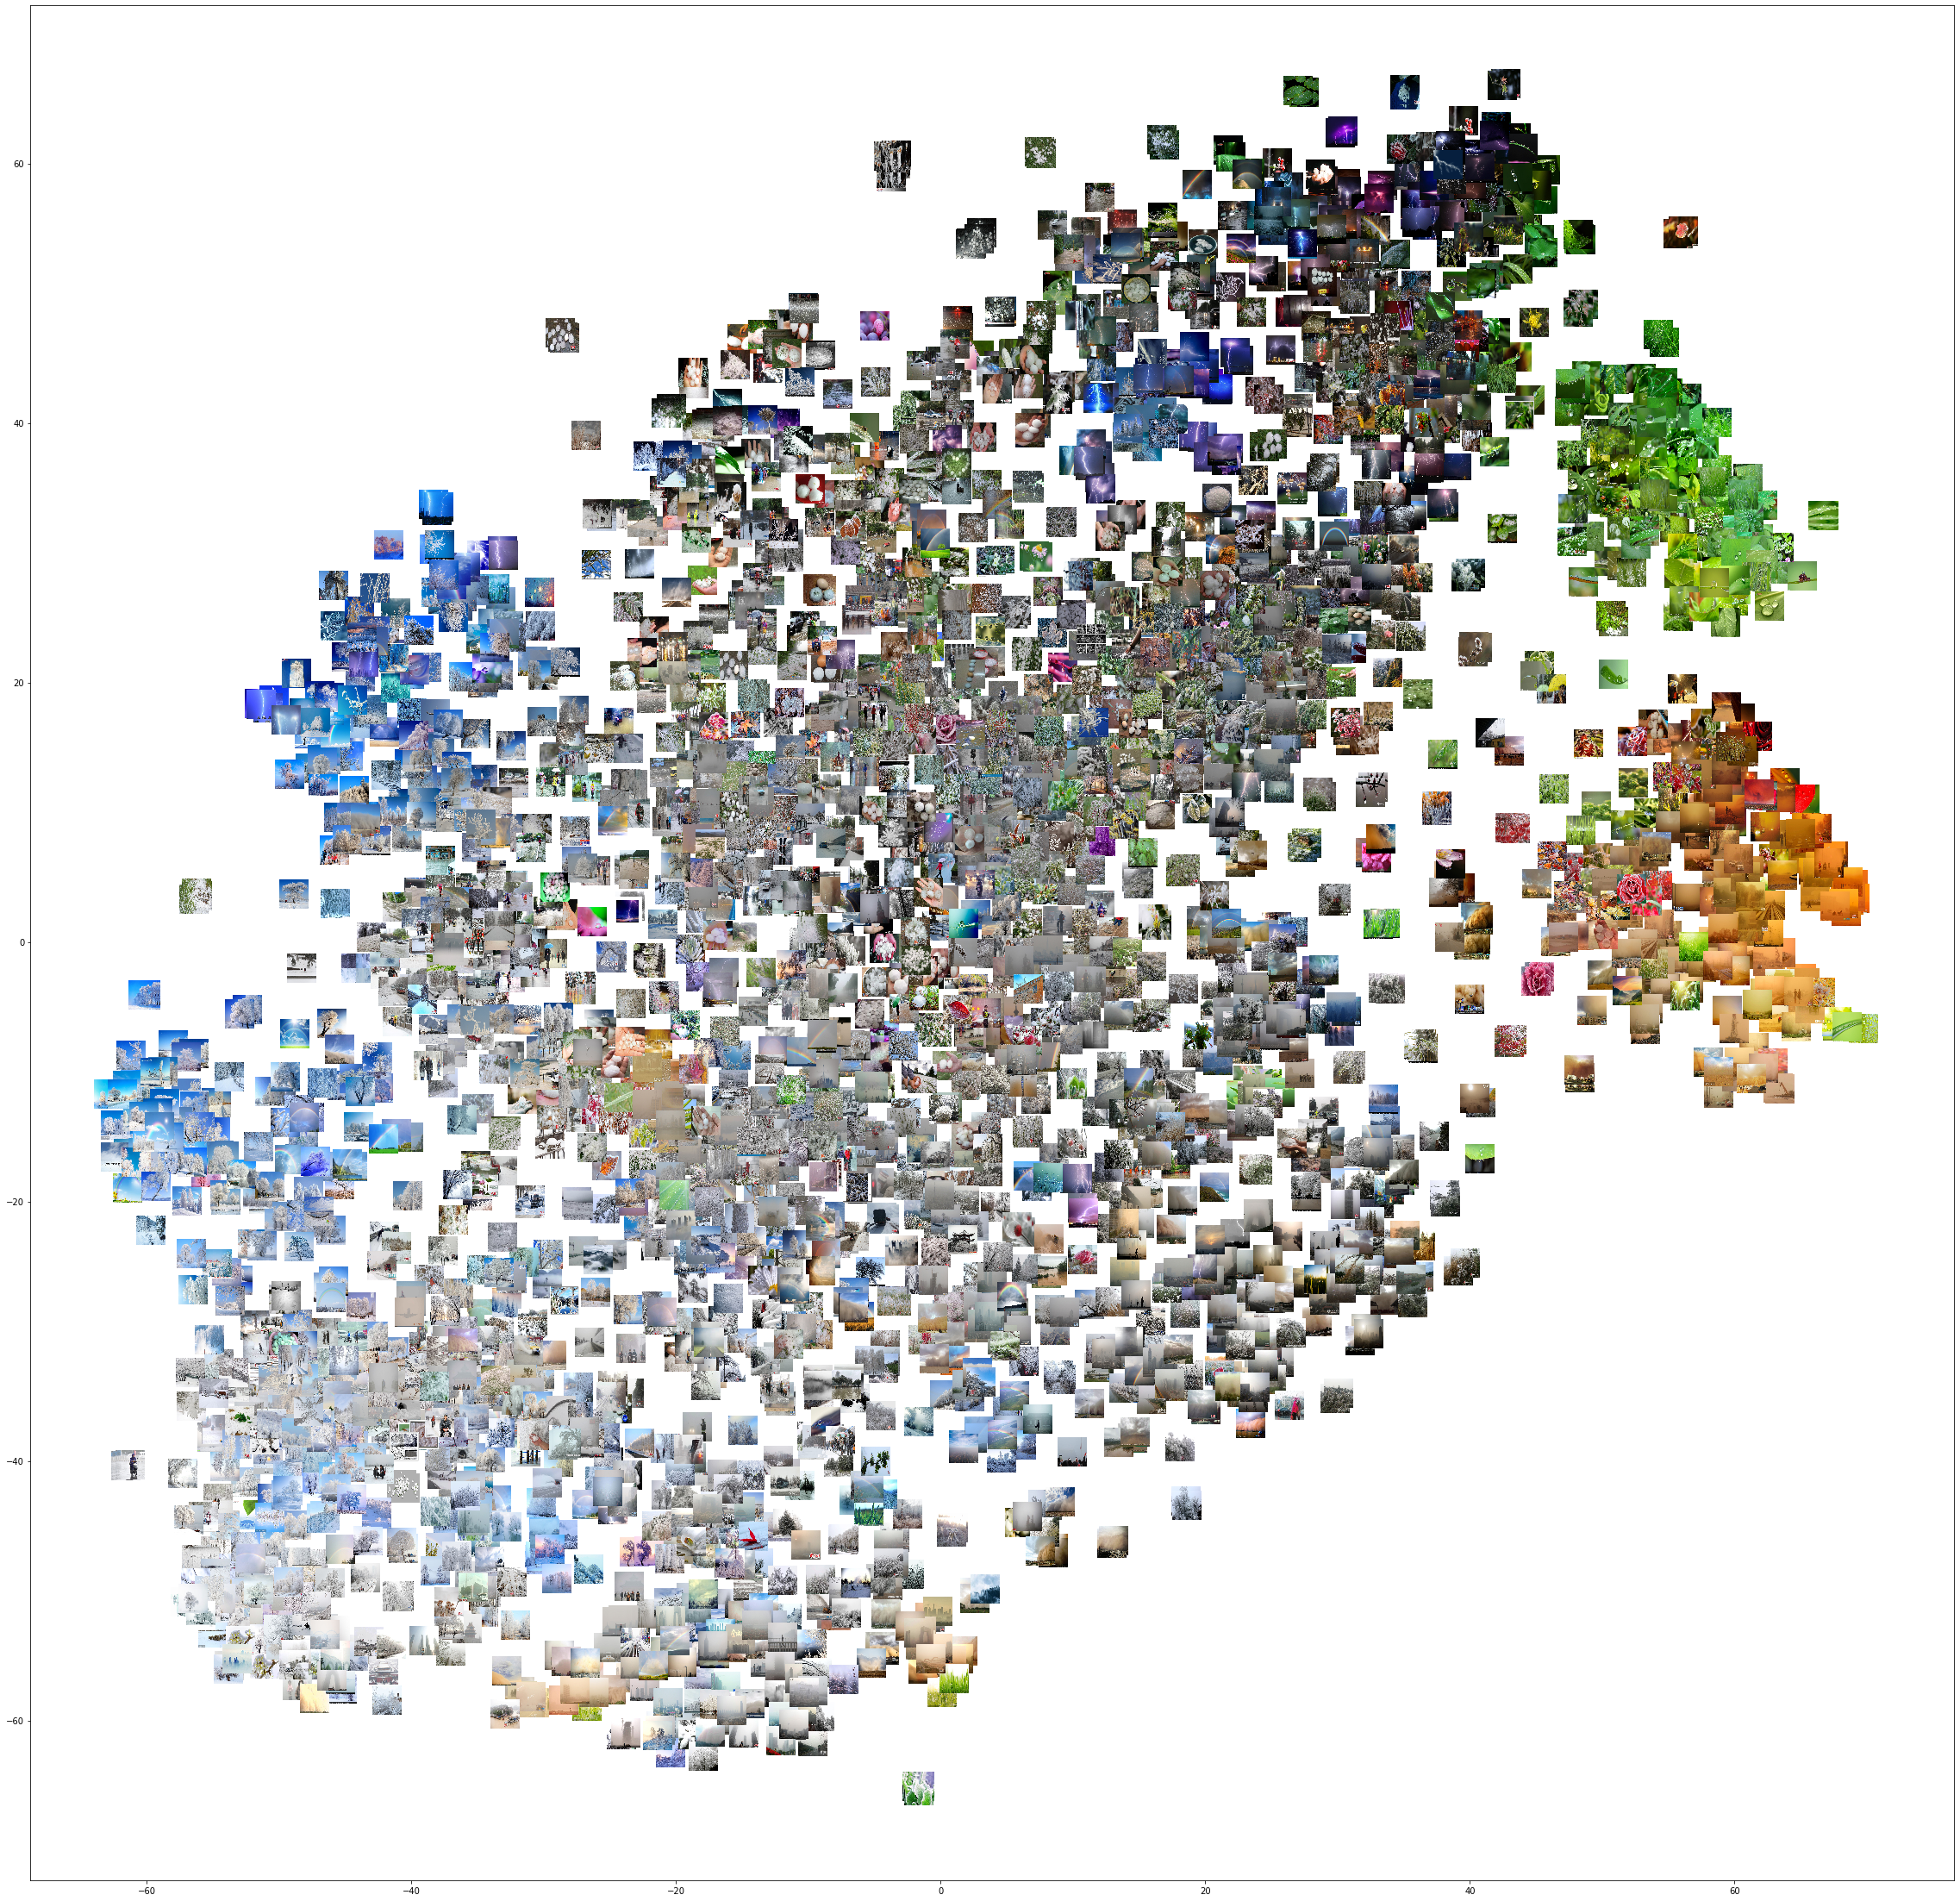

In [ ]:
np.random.seed(0)
plt.figure(figsize = (40,40)) # Making bigger plot

# Plotting TSNE output
plt.scatter(images_reduced.T[0], images_reduced.T[1])

image_zoom = 0.15 # Controlling size of plotted images

# Plotting each image using plot_image_at_point
for im, xy in zip(x_train[:n_ims], images_reduced):
  plot_image_at_point(im, xy, image_zoom)

# Classification with Transfer Learning

[Documentation](https://keras.io/guides/transfer_learning/)

### Parameters

In order to compare models. I kept the batch size and epochs constant across all models. The values are selected were:
1. Batch Size = 128
2. Epochs = 5

I felt these values allowed for decent efficiency and accuracy given every model.

*Fun Fact*: To fully take advantage of the GPU when running neural networks, use a batch size that is a power of 2. This is something I came across when doing some research on neural networks. The reasoning as to why is beyond my understanding of computer processing and hardware, but I find it very interesting!

### Image Augmentation

In order to avoid overfitting, I will use image augmentation to slightly change the appearance of images. This will generalize the model and hopefully lead to better predictions for out of sample data. The data augmentation used here does a combination of mirroring the image horizontally and/or rotating the image slightly.

Do note that there is a weird bug related to image shape after data augmentation. To get around it, run the cells in this image augmentation section. Then, run the model building cell for EfficientNetB0. This should throw a warning. Then, rerun the cell below here titled with the data_augmentation variable. Now you can go back and rerun the EfficientNetB0 cell with no warning. This is really annoying and hopefully gets fixed in a future update.

In [ ]:
# Create layer to augment data
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(0.1),]
)

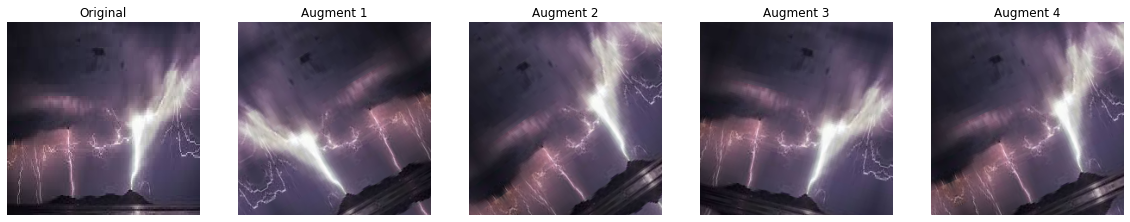

In [ ]:
# Visualizing image augmentations
augmented_image_array = x_train[0].reshape(1,224,224,3)

for i in range(4):
  # Calling data_augmentation layer
  augmented_image = data_augmentation(x_train[0], training = True)
  # Changing image back to numpy array
  numpy_image = augmented_image.numpy().astype('int32')
  augmented_image_array = np.append(augmented_image_array, 
                                    numpy_image.reshape(1,224,224,3),
                                    axis = 0)

plot_images_in_a_row(augmented_image_array, ['Original', 'Augment 1',
                                             'Augment 2', 'Augment 3',
                                             'Augment 4'])

### Model Assessment Function

Produces the classification report and confusion matrix of the test data for a given model.

In [ ]:
# Assess the performance of a given model
def model_assessment(model_name):

  # Predictions of model on testing dataset
  # Note: Each prediction is probability vector of length 11
      # Use np.argmax to get prediction with highest probability
  y_pred = model_name.predict(x_test, verbose=1)


  # Names of classes
  categories = ['dew','fogsmog','frost','glaze','hail',
                    'lightning','rain','rainbow','rime',
                    'sandstorm','snow']

  # Creating confusion matrix
  cm = confusion_matrix(y_test_num, np.argmax(y_pred, axis = 1))
  # Plotting confusion matrix
  cmd = ConfusionMatrixDisplay.from_predictions(y_test_num, np.argmax(y_pred, axis = 1),
                                              display_labels=categories)
  # Makes the plot bigger
  fig = cmd.ax_.get_figure()
  fig.set_figwidth(10)
  fig.set_figheight(10)

  # Printing classification report
  print(classification_report(y_test_num, np.argmax(y_pred, axis = 1),
                            target_names = categories))

## EfficientNetB0

### Model

Input layer: Expects RGB images on [0, 255] integer scale with shape (224, 224, 3)

Data Augmentation layer: Prevent overfitting (See above)
* Weird bug when running the first time
* Still works, but see comment in code cell and data augmentation text

EfficientNetB0: Image classification model with high efficiency and accuracy for transfer learning uses. The B0 version of EfficientNet specifically focuses on efficiency.

GlobalAvgPooling2D / BatchNormalization Layers: Connect the CNN to our top layer

Dropout Layer: Prevent overfitting

Top Layer: Dense layer expecting classification on 11 classes

In [ ]:
# EfficientNetB0 model with imagenet weights
base_model_ENB0 = keras.applications.EfficientNetB0(
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    include_top = False
)
# Freezing EfficientNetB0 model
base_model_ENB0.trainable = False

# Inputs with correct shape
inputs = keras.Input(shape = (224, 224, 3))

# Data augmentation layer
  # Weird Bug: Run this cell first, get error, then rerun data augmentation cell, then run this cell again...should work
x = data_augmentation(inputs)

# Calling EfficientNetB0 model
x = base_model_ENB0(x, training = False)

# Help connect EfficientNetB0 to top layer efficiently
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)

# Dropout layer to further avoid overfitting
x = keras.layers.Dropout(0.2)(x)

# Getting correct number of output classes
outputs = keras.layers.Dense(11, activation = 'softmax')(x)

# Connecting inputs and outputs
model_ENB0 = keras.Model(inputs, outputs)

# Using Adam as a general good choice for optimization
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

# Compiling model with 'categorical_crossentropy' to reduce loss between labels and predictions
model_ENB0.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model_ENB0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0   

In [ ]:
model_ENB0.fit(x_train, y_train_cat, batch_size = 128, epochs = 5,
          validation_data = (x_test, y_test_cat))

Epoch 1/5
40/40 [==============================] - 15s 365ms/step - loss: 0.4399 - accuracy: 0.8838 - val_loss: 0.5312 - val_accuracy: 0.8572
Epoch 2/5
40/40 [==============================] - 14s 355ms/step - loss: 0.4318 - accuracy: 0.8934 - val_loss: 0.6276 - val_accuracy: 0.8555
Epoch 3/5
40/40 [==============================] - 14s 359ms/step - loss: 0.3346 - accuracy: 0.9066 - val_loss: 0.6132 - val_accuracy: 0.8519
Epoch 4/5
40/40 [==============================] - 16s 411ms/step - loss: 0.3499 - accuracy: 0.9000 - val_loss: 0.6738 - val_accuracy: 0.8531
Epoch 5/5
40/40 [==============================] - 17s 424ms/step - loss: 0.3132 - accuracy: 0.9072 - val_loss: 0.6394 - val_accuracy: 0.8549


### Assessment

This EfficientNetB0 model performed extremely well!
1. Train Accuracy: 90.72%
2. Test Accuracy: 85.49%
3. Time: 76 seconds

Below, is the classification report and confusion matrix of the predictions on the test set. It appears that there are two main spots where misclassification is relatively common:

Sandstorm vs FogSmog
* This is intuitive as a sandstorm and fogsmog can look very similar. The characteristics for both images are generally washed-out, blurry colors, so it is easy to see where the model gets confused. This is especially true if there is a photo of a darker sandstorm.

Frost vs Glaze vs Rime
* These misclassifications are also intuitive. Before starting this project, I did not know there were 3 different types of ice: Frost, Rime, and Glaze. I personally cannot tell the difference when looking at photos. In all honesty, it is surprising to me that the model was able to classify these 3 categories so well.

Snow vs Glaze
* Once again, not a surprising misclassification given the similarities in the images seen during tSNE.

53/53 [==============================] - 5s 56ms/step
              precision    recall  f1-score   support

         dew       0.94      0.90      0.92       188
     fogsmog       0.88      0.84      0.86       203
       frost       0.75      0.73      0.74       112
       glaze       0.63      0.79      0.70       161
        hail       0.97      0.95      0.96       137
   lightning       0.97      0.97      0.97        90
        rain       0.89      0.85      0.87       128
     rainbow       0.97      0.95      0.96        65
        rime       0.87      0.85      0.86       290
   sandstorm       0.82      0.89      0.86       158
        snow       0.86      0.75      0.80       156

    accuracy                           0.85      1688
   macro avg       0.87      0.86      0.86      1688
weighted avg       0.86      0.85      0.86      1688



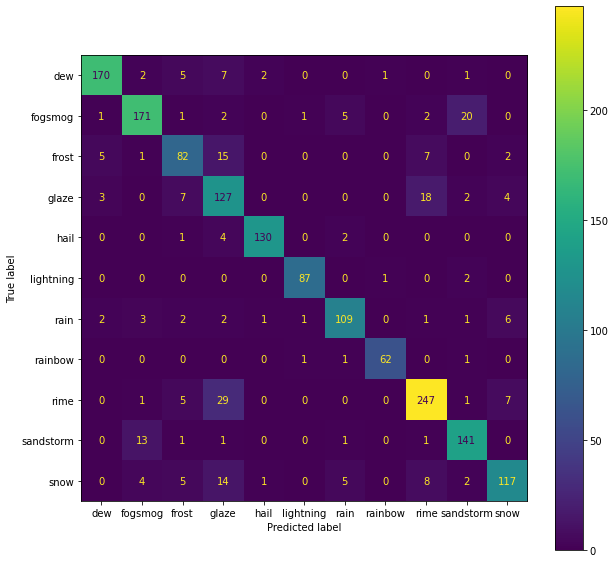

In [ ]:
model_assessment(model_ENB0)

## MobileNetV2

### Model

Input layer: Expects RGB images on [0, 255] scale with shape (224, 224, 3)

Data Augmentation layer: Prevent overfitting (See above)

Rescale layer: Rescales (224, 224, 3) RGB images on [0, 255] scale to (224, 224, 3) RGB images on [-1, 1] scale. The [-1, 1] scale is what MobileNet expects.
* [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/preprocess_input)

MobileNetV2: Another image classification model with high efficiency and accuracy for transfer learning uses. The V2 version of MobileNet improves on accuracy from V1 while maintaining similar size and computational cost.
* [Documentation](https://keras.io/api/applications/mobilenet/)

GlobalAvgPooling2D / BatchNormalization Layers: Connect the CNN to our top layer

Dropout Layer: Prevent overfitting

Top Layer: Dense layer with expecting classification on 11 options

In [ ]:
# MobileNetV2 model with imagenet weights
base_model_MNV2 = keras.applications.MobileNetV2(
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    include_top = False
)
# Freezing MobileNetV2 model
base_model_MNV2.trainable = False

# Inputs with correct shape
inputs = keras.Input(shape = (224, 224, 3))

# Data augmentation layer
x = data_augmentation(inputs)

# Scaling RGB values to [-1,1] values
x = keras.applications.mobilenet_v2.preprocess_input(x)

# Calling MobileNetV2 model
x = base_model_MNV2(x, training = False)

# Help connect MobileNetV2 to top layer efficiently
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)

# Dropout layer to further avoid overfitting
x = keras.layers.Dropout(0.2)(x)

# Getting correct number of output classes
outputs = keras.layers.Dense(11, activation = 'softmax')(x)

# Connecting inputs and outputs
model_MNV2 = keras.Model(inputs, outputs)

# Using Adam as a general good choice for optimization
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

# Compiling model with 'categorical_crossentropy' to reduce loss between labels and predictions
model_MNV2.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model_MNV2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
model_MNV2.fit(x_train, y_train_cat, batch_size = 128, epochs = 5,
          validation_data = (x_test, y_test_cat))

Epoch 1/5
40/40 [==============================] - 16s 300ms/step - loss: 1.0692 - accuracy: 0.7376 - val_loss: 0.8113 - val_accuracy: 0.7541
Epoch 2/5
40/40 [==============================] - 11s 266ms/step - loss: 0.6640 - accuracy: 0.8192 - val_loss: 0.6616 - val_accuracy: 0.8033
Epoch 3/5
40/40 [==============================] - 11s 278ms/step - loss: 0.6518 - accuracy: 0.8326 - val_loss: 0.8161 - val_accuracy: 0.7968
Epoch 4/5
40/40 [==============================] - 11s 278ms/step - loss: 0.5167 - accuracy: 0.8600 - val_loss: 0.7004 - val_accuracy: 0.8241
Epoch 5/5
40/40 [==============================] - 10s 263ms/step - loss: 0.4788 - accuracy: 0.8620 - val_loss: 0.7097 - val_accuracy: 0.8276


### Assessment

The MobileNetV2 model performs very similarly to the Efficient Net B0 model.
1. Train Accuracy: 86.20%
2. Test Accuracy: 82.76%
3. Time: 59 seconds

In general, there is less accuracy across all categories, though it is faster. Additionally, two common spots of predictions are the same as those in the ENB0 model:
1. Sandstorm vs Fogsmog
2. The 3 different types of ice

This time, the common misclassification of Snow is Rime rather than Glaze.

That being said, it is faster than the EfficientNetB0 model. However, I believe that the accuracy gains justify using EfficientNetB0 over MobileNetV2.

53/53 [==============================] - 3s 37ms/step
              precision    recall  f1-score   support

         dew       0.95      0.96      0.96       188
     fogsmog       0.78      0.90      0.84       203
       frost       0.86      0.63      0.73       112
       glaze       0.70      0.76      0.73       161
        hail       0.96      0.89      0.92       137
   lightning       0.97      0.96      0.96        90
        rain       0.80      0.90      0.85       128
     rainbow       0.95      0.94      0.95        65
        rime       0.74      0.90      0.81       290
   sandstorm       0.86      0.65      0.74       158
        snow       0.81      0.59      0.68       156

    accuracy                           0.83      1688
   macro avg       0.85      0.83      0.83      1688
weighted avg       0.83      0.83      0.82      1688



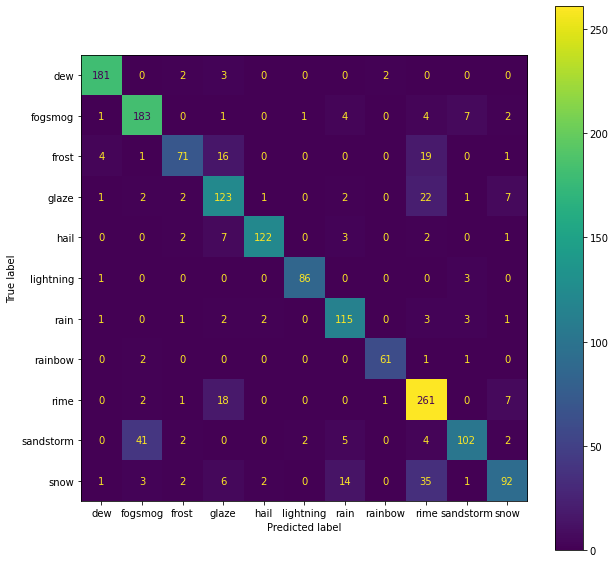

In [ ]:
model_assessment(model_MNV2)

## ResNet50

### Model

Input layer: Expects RGB images on [0, 255] scale with shape (224, 224, 3)

Data Augmentation layer: Prevent overfitting (See above)

Rescale layer: Zeroes (224, 224, 3) RGB images on [0, 255] scale with respect to imagenet scale. Additionally, converts images from RGB shape to BGR shape.
* [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input)

ResNet50: A 50-layer image classification model with reasonable efficiency and accuracy for transfer learning uses.
* [Documentation](https://keras.io/api/applications/resnet/#resnet50-function)

GlobalAvgPooling2D / BatchNormalization Layers: Connect the CNN to our top layer

Dropout Layer: Prevent overfitting

Top Layer: Dense layer with expecting classification on 11 options

In [ ]:
# ResNet50 model with imagenet weights
base_model_RN50 = keras.applications.resnet.ResNet50(
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    include_top = False
)
# Freezing MobileNetV2 model
base_model_RN50.trainable = False

# Inputs with correct shape
inputs = keras.Input(shape = (224, 224, 3))

# Data augmentation layer
  # Weird Bug: Run this cell first, get error, then rerun data augmentation cell, then run this cell again...should work
x = data_augmentation(inputs)

# Preprocessing inputs according to ResNet50 specifications
x = keras.applications.resnet50.preprocess_input(x)

# Calling MobileNetV2 model
x = base_model_RN50(inputs, training = False)

# Help connect MobileNetV2 to top layer efficiently
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)

# Dropout layer to further avoid overfitting
x = keras.layers.Dropout(0.2)(x)

# Getting correct number of output classes
outputs = keras.layers.Dense(11, activation = 'softmax')(x)

# Connecting inputs and outputs
model_RN50 = keras.Model(inputs, outputs)

# Using Adam as a general good choice for optimization
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

# Compiling model with 'categorical_crossentropy' to reduce loss between labels and predictions
model_RN50.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model_RN50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 11)                2253

In [ ]:
model_RN50.fit(x_train, y_train_cat, batch_size = 128, epochs = 5,
          validation_data = (x_test, y_test_cat))

Epoch 1/5
40/40 [==============================] - 29s 604ms/step - loss: 1.0958 - accuracy: 0.7734 - val_loss: 0.9555 - val_accuracy: 0.7796
Epoch 2/5
40/40 [==============================] - 21s 534ms/step - loss: 0.5802 - accuracy: 0.8672 - val_loss: 0.7114 - val_accuracy: 0.8383
Epoch 3/5
40/40 [==============================] - 21s 516ms/step - loss: 0.4039 - accuracy: 0.8996 - val_loss: 0.7415 - val_accuracy: 0.8436
Epoch 4/5
40/40 [==============================] - 21s 523ms/step - loss: 0.3105 - accuracy: 0.9154 - val_loss: 0.8283 - val_accuracy: 0.8329
Epoch 5/5
40/40 [==============================] - 21s 531ms/step - loss: 0.3246 - accuracy: 0.9184 - val_loss: 0.8996 - val_accuracy: 0.8383


### Assessment

The ResNet50 model produces very similar results to the previous two models.
1. Train Accuracy: 91.84%
2. Test Accuracy: 83.83%
3. Time: 113 seconds

This model is slightly more accurate for the test data than the MobileNetV2 model, but slightly less accurate than the EfficientNetB0 model. 

That being said, the misclassifications are spread a little differently. The Sandstorm vs FogSmog classification is more accurate than the previous two, but the classifications between the three different types of ice is less accurate. Further, there are more misclassifications between the types of ice and snow.

The other notable thing about this model is the slow speed. This model is much slower than the MobileNetV2. Further, it is slower than the EfficientNetB0 model while also being less accurate. In my opinion, when taking both accuracy and speed into account, this model performs the worst.

53/53 [==============================] - 7s 95ms/step
              precision    recall  f1-score   support

         dew       0.93      0.94      0.93       188
     fogsmog       0.86      0.87      0.87       203
       frost       0.69      0.76      0.72       112
       glaze       0.80      0.58      0.68       161
        hail       0.92      0.93      0.92       137
   lightning       1.00      0.87      0.93        90
        rain       0.80      0.85      0.83       128
     rainbow       0.91      0.92      0.92        65
        rime       0.80      0.87      0.83       290
   sandstorm       0.90      0.89      0.89       158
        snow       0.71      0.74      0.73       156

    accuracy                           0.84      1688
   macro avg       0.85      0.84      0.84      1688
weighted avg       0.84      0.84      0.84      1688



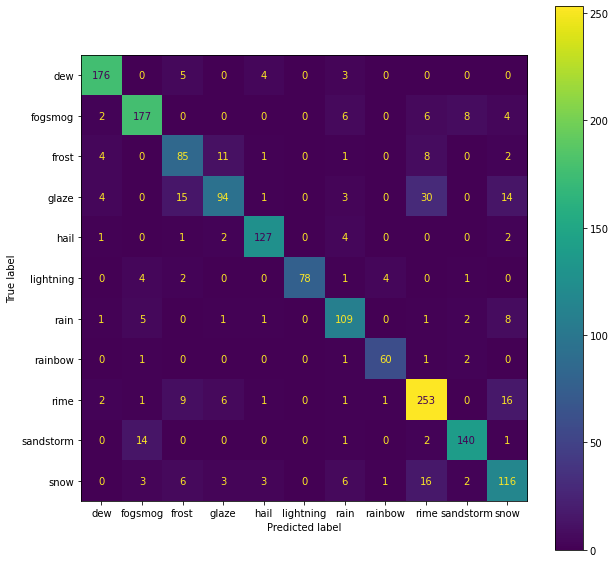

In [ ]:
model_assessment(model_RN50)

# Conclusion

Overall, all three models performed very well. The best model was the EfficientNetB0 model with an accuracy of around 90% on our training data and 85% on our test data. This was achieved all while being the second most efficient model with a time of 76 seconds.

Additionally, the two main points of misclassification were between (Sandstorm vs FogSmog) and (Rime vs Glaze vs Frost). The first misclassification did come as a surprise to me, but the second did not. After all, I cannot even tell the difference between the three!

**Improvements**

The next steps to improving this project is tuning some of the parameters in the CNN's. During this project, I completely froze the CNN's I used during learning. However, if one were to tune say the top 30% of layers in each model, higher prediction accuracy would be achieved. Next, cross-validation could be conducted to determine batch_size and epochs to determine that best model!

I hope you enjoyed reading through my project :)